In [1]:
library(tidyverse)
library(Amelia)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ───────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: Rcpp

## 
## Amelia II: Multiple Imputation
## (Version 1.8.0, built: 2021-05-26)
## Copyright (C) 2005-2023 James Honaker, Gary King and Matthew Blackwell
## Refer to http://gking.harvard.edu/amelia/ for more information
## 



In [2]:
df = read.csv("../data/train.csv", header = TRUE)
head(df)
str(df)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39,False,0,0,0,0,0,Maham Ofracculy,False
2,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24,False,109,9,25,549,44,Juanna Vines,True
3,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58,True,43,3576,0,6715,49,Altark Susent,False
4,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33,False,0,1283,371,3329,193,Solam Susent,False
5,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16,False,303,70,151,565,2,Willy Santantines,True
6,0005_01,Earth,False,F/0/P,PSO J318.5-22,44,False,0,483,0,291,0,Sandie Hinetthews,True


'data.frame':	8693 obs. of  14 variables:
 $ PassengerId : chr  "0001_01" "0002_01" "0003_01" "0003_02" ...
 $ HomePlanet  : chr  "Europa" "Earth" "Europa" "Europa" ...
 $ CryoSleep   : chr  "False" "False" "False" "False" ...
 $ Cabin       : chr  "B/0/P" "F/0/S" "A/0/S" "A/0/S" ...
 $ Destination : chr  "TRAPPIST-1e" "TRAPPIST-1e" "TRAPPIST-1e" "TRAPPIST-1e" ...
 $ Age         : num  39 24 58 33 16 44 26 28 35 14 ...
 $ VIP         : chr  "False" "False" "True" "False" ...
 $ RoomService : num  0 109 43 0 303 0 42 0 0 0 ...
 $ FoodCourt   : num  0 9 3576 1283 70 ...
 $ ShoppingMall: num  0 25 0 371 151 0 3 0 17 0 ...
 $ Spa         : num  0 549 6715 3329 565 ...
 $ VRDeck      : num  0 44 49 193 2 0 0 NA 0 0 ...
 $ Name        : chr  "Maham Ofracculy" "Juanna Vines" "Altark Susent" "Solam Susent" ...
 $ Transported : chr  "False" "True" "False" "False" ...


In [3]:
cabin_splitted = str_split(df$Cabin, '/', simplify = TRUE)

In [4]:
df = df %>% mutate(Cabin_deck = cabin_splitted[, 1], 
                   Cabin_num = as.integer(cabin_splitted[, 2]), 
                   Cabin_side = cabin_splitted[, 3]) %>% select(-Cabin)

In [5]:
df$Cabin_deck[df$Cabin_deck == ""] = NA
df$Cabin_num[df$Cabin_num == ""] = NA
df$Cabin_side[df$Cabin_side == ""] = NA
df$HomePlanet[df$HomePlanet == ""] = NA
df$Destination[df$Destination == ""] = NA
df$CryoSleep[df$CryoSleep == ""] = NA
df$VIP[df$VIP == ""] = NA

In [6]:
cs_idFalse = df %>% filter(is.na(CryoSleep), (RoomService!=0 | FoodCourt != 0 | ShoppingMall != 0 | Spa != 0 |
                     VRDeck != 0)) %>% select(PassengerId) 

df[df$PassengerId %in% cs_idFalse[,1],]$CryoSleep = 'False'

In [7]:
expenses_IdZero_RoomService = df %>% filter(CryoSleep == "True", is.na(RoomService)) %>% select(PassengerId)
expenses_IdZero_VRDeck = df %>% filter(CryoSleep == "True", is.na(VRDeck)) %>% select(PassengerId)
expenses_IdZero_Spa = df %>% filter(CryoSleep == "True", is.na(Spa)) %>% select(PassengerId)
expenses_IdZero_ShoppingMall = df %>% filter(CryoSleep == "True", is.na(ShoppingMall)) %>% select(PassengerId)
expenses_IdZero_FoodCourt = df %>% filter(CryoSleep == "True", is.na(FoodCourt)) %>% select(PassengerId)

In [8]:
df[df$PassengerId %in% expenses_IdZero_RoomService[,1],]$RoomService = 0
df[df$PassengerId %in% expenses_IdZero_VRDeck[,1],]$VRDeck = 0
df[df$PassengerId %in% expenses_IdZero_Spa[,1],]$Spa = 0
df[df$PassengerId %in% expenses_IdZero_ShoppingMall[,1],]$ShoppingMall = 0
df[df$PassengerId %in% expenses_IdZero_FoodCourt[,1],]$FoodCourt = 0

In [9]:
df %>% mutate(Total_expens = RoomService+ShoppingMall + FoodCourt +Spa + VRDeck) %>%
    filter(Age<13) %>% count(Total_expens)

Total_expens,n
<dbl>,<int>
0,763
NA,43


In [10]:
expenses_Idminors = df %>% mutate(Total_expens = RoomService + 
                                  ShoppingMall + FoodCourt +Spa + VRDeck) %>%
    filter(Age<13) %>% select(PassengerId)

df[df$PassengerId %in% expenses_Idminors[,1],]$ShoppingMall = 0
df[df$PassengerId %in% expenses_Idminors[,1],]$FoodCourt = 0
df[df$PassengerId %in% expenses_Idminors[,1],]$Spa = 0
df[df$PassengerId %in% expenses_Idminors[,1],]$VRDeck = 0
df[df$PassengerId %in% expenses_Idminors[,1],]$RoomService = 0

In [11]:
df %>% mutate(Total_expens = RoomService+ShoppingMall + FoodCourt +Spa + VRDeck) %>%
    filter(Age<13) %>% count(Total_expens)

Total_expens,n
<dbl>,<int>
0,806


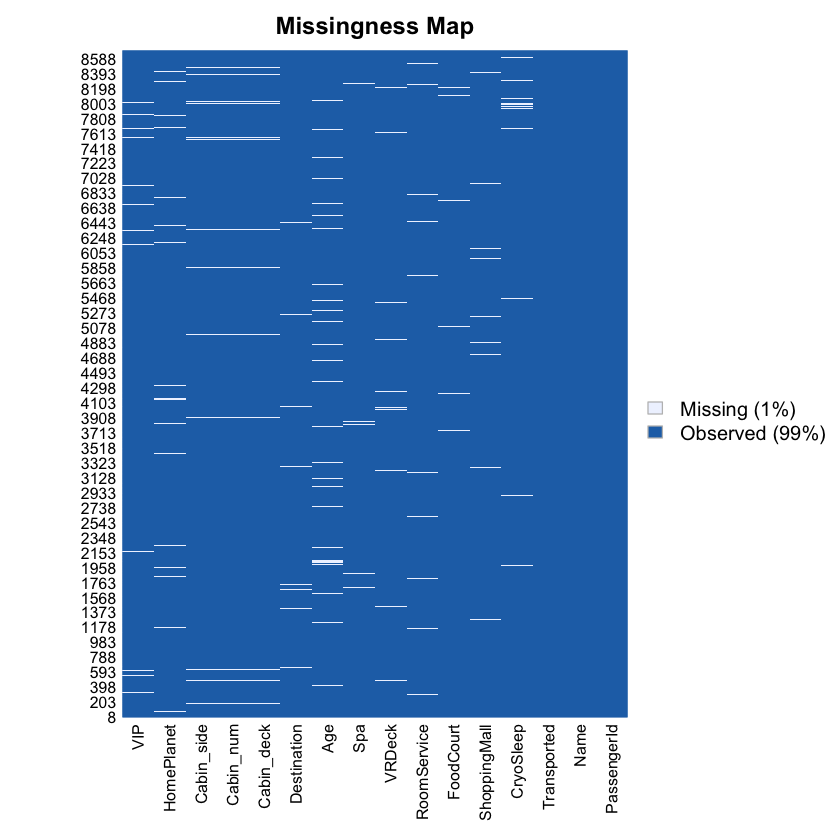

In [12]:
missmap(df)

In [13]:
sum(!complete.cases(df))/nrow(df)

[1] 0.1715173

In [14]:
library(VIM)

df_knnImputed = kNN(df %>% select(-c(PassengerId,Name,Cabin_num)) ,k = 20,imp_var = FALSE)

Loading required package: colorspace

Loading required package: grid

VIM is ready to use.


Suggestions and bug-reports can be submitted at: https://github.com/statistikat/VIM/issues


Attaching package: ‘VIM’


The following object is masked from ‘package:datasets’:

    sleep




In [15]:
df_knnImputed[which(is.na(df$CryoSleep)),]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_deck,Cabin_side
,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
93,Earth,True,TRAPPIST-1e,2,False,0,0,0.0,0,0,True,G,P
112,Mars,False,TRAPPIST-1e,26,False,0,0,0.0,0,0,True,F,P
176,Earth,True,PSO J318.5-22,52,False,0,0,0.0,0,0,True,G,P
267,Europa,True,TRAPPIST-1e,43,False,0,0,0.0,0,0,True,B,S
393,Europa,True,55 Cancri e,27,False,0,0,0.0,0,0,True,B,P
627,Mars,True,TRAPPIST-1e,39,False,0,0,0.0,0,0,True,E,S
683,Mars,True,TRAPPIST-1e,2,False,0,0,0.0,0,0,True,F,P
692,Europa,True,55 Cancri e,54,False,0,0,0.0,0,0,True,C,S
705,Mars,True,TRAPPIST-1e,47,False,0,0,0.0,0,0,True,F,P


In [16]:
df_knnImputed$PassengerId = df$PassengerId

In [17]:
str(df_knnImputed)

'data.frame':	8693 obs. of  14 variables:
 $ HomePlanet  : chr  "Europa" "Earth" "Europa" "Europa" ...
 $ CryoSleep   : chr  "False" "False" "False" "False" ...
 $ Destination : chr  "TRAPPIST-1e" "TRAPPIST-1e" "TRAPPIST-1e" "TRAPPIST-1e" ...
 $ Age         : num  39 24 58 33 16 44 26 28 35 14 ...
 $ VIP         : chr  "False" "False" "True" "False" ...
 $ RoomService : num  0 109 43 0 303 0 42 0 0 0 ...
 $ FoodCourt   : num  0 9 3576 1283 70 ...
 $ ShoppingMall: num  0 25 0 371 151 0 3 0 17 0 ...
 $ Spa         : num  0 549 6715 3329 565 ...
 $ VRDeck      : num  0 44 49 193 2 0 0 0 0 0 ...
 $ Transported : chr  "False" "True" "False" "False" ...
 $ Cabin_deck  : chr  "B" "F" "A" "A" ...
 $ Cabin_side  : chr  "P" "S" "S" "S" ...
 $ PassengerId : chr  "0001_01" "0002_01" "0003_01" "0003_02" ...


In [18]:
df_knnImputed = df_knnImputed[,c(14,1:13)]

In [19]:
write.csv(df_knnImputed,'../data/train_pr_KnnImp.csv', row.names = FALSE)

## Test data

In [20]:
df_test = read.csv("../data/test.csv", header = TRUE)

In [21]:
cabin_splitted_test = str_split(df_test$Cabin, '/', simplify = TRUE)

In [22]:
df_test_imputed = df_test %>% mutate(Cabin_deck = cabin_splitted_test[, 1], 
                   Cabin_num = as.integer(cabin_splitted_test[, 2]), 
                   Cabin_side = cabin_splitted_test[, 3]) %>% select(-Cabin)

In [23]:
df_test_imputed$Cabin_deck[df_test_imputed$Cabin_deck == ""] = NA
df_test_imputed$Cabin_num[df_test_imputed$Cabin_num == ""] = NA
df_test_imputed$Cabin_side[df_test_imputed$Cabin_side == ""] = NA
df_test_imputed$HomePlanet[df_test_imputed$HomePlanet == ""] = NA
df_test_imputed$Destination[df_test_imputed$Destination == ""] = NA
df_test_imputed$CryoSleep[df_test_imputed$CryoSleep == ""] = NA
df_test_imputed$VIP[df_test_imputed$VIP == ""] = NA

In [24]:
df_test_imputed %>% filter(RoomService!=0 | FoodCourt != 0 | ShoppingMall != 0 | Spa != 0 |
                     VRDeck != 0) %>% count(CryoSleep)

CryoSleep,n
<chr>,<int>
False,2418
NA,55


In [25]:
cs_idFalse_test = df_test_imputed %>% filter(is.na(CryoSleep), (RoomService!=0 | FoodCourt != 0 | ShoppingMall != 0 | Spa != 0 |
                     VRDeck != 0)) %>% select(PassengerId) 

df_test_imputed[df_test_imputed$PassengerId %in% cs_idFalse_test[,1],]$CryoSleep = 'False'

In [26]:
expenses_IdZero_RoomService_test = df_test_imputed %>% filter(CryoSleep == "True", is.na(RoomService)) %>% select(PassengerId)
expenses_IdZero_VRDeck_test = df_test_imputed %>% filter(CryoSleep == "True", is.na(VRDeck)) %>% select(PassengerId)
expenses_IdZero_Spa_test = df_test_imputed %>% filter(CryoSleep == "True", is.na(Spa)) %>% select(PassengerId)
expenses_IdZero_ShoppingMall_test = df_test_imputed %>% filter(CryoSleep == "True", is.na(ShoppingMall)) %>% select(PassengerId)
expenses_IdZero_FoodCourt_test = df_test_imputed %>% filter(CryoSleep == "True", is.na(FoodCourt)) %>% select(PassengerId)

df_test_imputed[df_test_imputed$PassengerId %in% expenses_IdZero_RoomService_test[,1],]$RoomService = 0
df_test_imputed[df_test_imputed$PassengerId %in% expenses_IdZero_VRDeck_test[,1],]$VRDeck = 0
df_test_imputed[df_test_imputed$PassengerId %in% expenses_IdZero_Spa_test[,1],]$Spa = 0
df_test_imputed[df_test_imputed$PassengerId %in% expenses_IdZero_ShoppingMall_test[,1],]$ShoppingMall = 0
df_test_imputed[df_test_imputed$PassengerId %in% expenses_IdZero_FoodCourt_test[,1],]$FoodCourt = 0

In [27]:
df_test_imputed %>% mutate(Total_expens = RoomService+ShoppingMall + FoodCourt +Spa + VRDeck) %>%
    filter(Age<13) %>% count(Total_expens)

Total_expens,n
<dbl>,<int>
0,329
NA,22


In [28]:
expenses_Idminors = df_test_imputed %>% mutate(Total_expens = RoomService + 
                                  ShoppingMall + FoodCourt +Spa + VRDeck) %>%
    filter(Age<13) %>% select(PassengerId)

df_test_imputed[df_test_imputed$PassengerId %in% expenses_Idminors[,1],]$ShoppingMall = 0
df_test_imputed[df_test_imputed$PassengerId %in% expenses_Idminors[,1],]$FoodCourt = 0
df_test_imputed[df_test_imputed$PassengerId %in% expenses_Idminors[,1],]$Spa = 0
df_test_imputed[df_test_imputed$PassengerId %in% expenses_Idminors[,1],]$VRDeck = 0
df_test_imputed[df_test_imputed$PassengerId %in% expenses_Idminors[,1],]$RoomService = 0

In [29]:
merged_dfs = rbind(df %>% select(-c(PassengerId,Name,Cabin_num,Transported)),
                                 df_test_imputed %>%
                                 select(-c(PassengerId,Name,Cabin_num)))

In [30]:
merged_dfs

HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_deck,Cabin_side
<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Europa,False,TRAPPIST-1e,39,False,0,0,0,0,0,B,P
Earth,False,TRAPPIST-1e,24,False,109,9,25,549,44,F,S
Europa,False,TRAPPIST-1e,58,True,43,3576,0,6715,49,A,S
Europa,False,TRAPPIST-1e,33,False,0,1283,371,3329,193,A,S
Earth,False,TRAPPIST-1e,16,False,303,70,151,565,2,F,S
Earth,False,PSO J318.5-22,44,False,0,483,0,291,0,F,P
Earth,False,TRAPPIST-1e,26,False,42,1539,3,0,0,F,S
Earth,True,TRAPPIST-1e,28,False,0,0,0,0,0,G,S
Earth,False,TRAPPIST-1e,35,False,0,785,17,216,0,F,S


In [31]:
df_merged_knnImputed = kNN(merged_dfs,k = 20,imp_var = FALSE)

In [32]:
df_test_knnImputed = df_merged_knnImputed[-c(1:8693),]

In [33]:
df_test_knnImputed$PassengerId = df_test_imputed$PassengerId

In [34]:
df_test_knnImputed = df_test_knnImputed[,c(13,1:12)]
df_test_knnImputed

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_deck,Cabin_side
,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
8694,0013_01,Earth,True,TRAPPIST-1e,27,False,0.0,0,0,0,0.0,G,S
8695,0018_01,Earth,False,TRAPPIST-1e,19,False,0.0,9,0,2823,0.0,F,S
8696,0019_01,Europa,True,55 Cancri e,31,False,0.0,0,0,0,0.0,C,S
8697,0021_01,Europa,False,TRAPPIST-1e,38,False,0.0,6652,0,181,585.0,C,S
8698,0023_01,Earth,False,TRAPPIST-1e,20,False,10.0,0,635,0,0.0,F,S
8699,0027_01,Earth,False,TRAPPIST-1e,31,False,0.0,1615,263,113,60.0,F,P
8700,0029_01,Europa,True,55 Cancri e,21,False,0.0,0,0,0,0.0,B,P
8701,0032_01,Europa,True,TRAPPIST-1e,20,False,0.0,0,0,0,0.0,D,S
8702,0032_02,Europa,True,55 Cancri e,23,False,0.0,0,0,0,0.0,D,S


In [35]:
write.csv(df_test_knnImputed,'../data/test_pr_KnnImp.csv', row.names = FALSE)